[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/brauliobarahona/fpp3-python/blob/main/1 A tidy forecasting workflow.ipynb)

In [ ]:
!pip install statsforecast

In [42]:
# prompt: mount google drive
from google.colab import drive
drive.mount('/content/drive')

my_path = "/content/drive/MyDrive/EDAF/Intro_data_forecast/fpp3-python/"
# /content/drive/MyDrive/EDAF/Intro_data_forecast/fpp3-python/Assets

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. A tidy forecasting workflow
***

The process of producing forecasts for time series data can be broken down into a few steps.

![workflow-1](https://raw.githubusercontent.com/Nixtla/fpp3/main/Assets/workflow-1.png)

<img src="https://raw.githubusercontent.com/Nixtla/fpp3/main/Assets/workflow-1.png" alt="workflow" />


To illustrate the process, we will fit a ETS model to national GDP data stored in `global_economy`

## Data preparation (tidy)

The first step in forecasting is to prepare data in the correct format. This process may involve loading in data, identifying missing values, filtering the time series, and other pre-processing tasks. *Multiple pandas functions can be useful for this stage*

Many models have different data requirements; some require the series to be in time order, others require no missing values. Checking your data is an essential step to understanding its features and should always be done before models are estimated.

We will model GDP per capita over time; so first, we must compute the relevant variable.

In [43]:
#Import the libraries that we are going to use for the analysis:
import pandas as pd
import numpy as np
import statsforecast
import matplotlib.pyplot as plt

In [44]:
# Create a dataframe from a csv file
df = pd.read_csv(my_path + "Assets/global_economy_data.csv", delimiter=";")

df.head()

,Year,Afghanistan_gdp,Albania_gdp,Algeria_gdp,American Samoa_gdp,Andorra_gdp,Angola_gdp,Antigua and Barbuda_gdp,Argentina_gdp,Armenia_gdp,...,Uruguay_gdp_per_cap,Uzbekistan_gdp_per_cap,Vanuatu_gdp_per_cap,"Venezuela, RB_gdp_per_cap",Vietnam_gdp_per_cap,Virgin Islands (U.S.)_gdp_per_cap,West Bank and Gaza_gdp_per_cap,"Yemen, Rep._gdp_per_cap",Zambia_gdp_per_cap,Zimbabwe_gdp_per_cap
0,1960,537777811.1,NaN,2.723593e+09,NaN,NaN,NaN,NaN,NaN,NaN,...,489.350725,0.0,0.0,955.446418,0.0,0.0,0.0,0.0,232.188565,278.813847
1,1961,548888895.6,NaN,2.434727e+09,NaN,NaN,NaN,NaN,NaN,NaN,...,601.703003,0.0,0.0,970.356398,0.0,0.0,0.0,0.0,220.042067,280.828663
2,1962,546666677.8,NaN,2.001428e+09,NaN,NaN,NaN,NaN,2.445060e+10,NaN,...,656.713227,0.0,0.0,1023.355237,0.0,0.0,0.0,0.0,212.578449,276.688233
3,1963,751111191.1,NaN,2.702960e+09,NaN,NaN,NaN,NaN,1.827212e+10,NaN,...,584.291633,0.0,0.0,1077.403051,0.0,0.0,0.0,0.0,213.896759,277.479715
4,1964,800000044.4,NaN,2.909293e+09,NaN,NaN,NaN,NaN,2.560525e+10,NaN,...,741.244998,0.0,0.0,864.471221,0.0,0.0,0.0,0.0,242.384472,281.558896


## Plot the data (visualise)

As we have seen in Chapter 2, visualisation is an essential step in understanding the data. Looking at your data allows you to identify common patterns, and subsequently specify an appropriate model.

The data for one country in our example are plotted the next Figure:

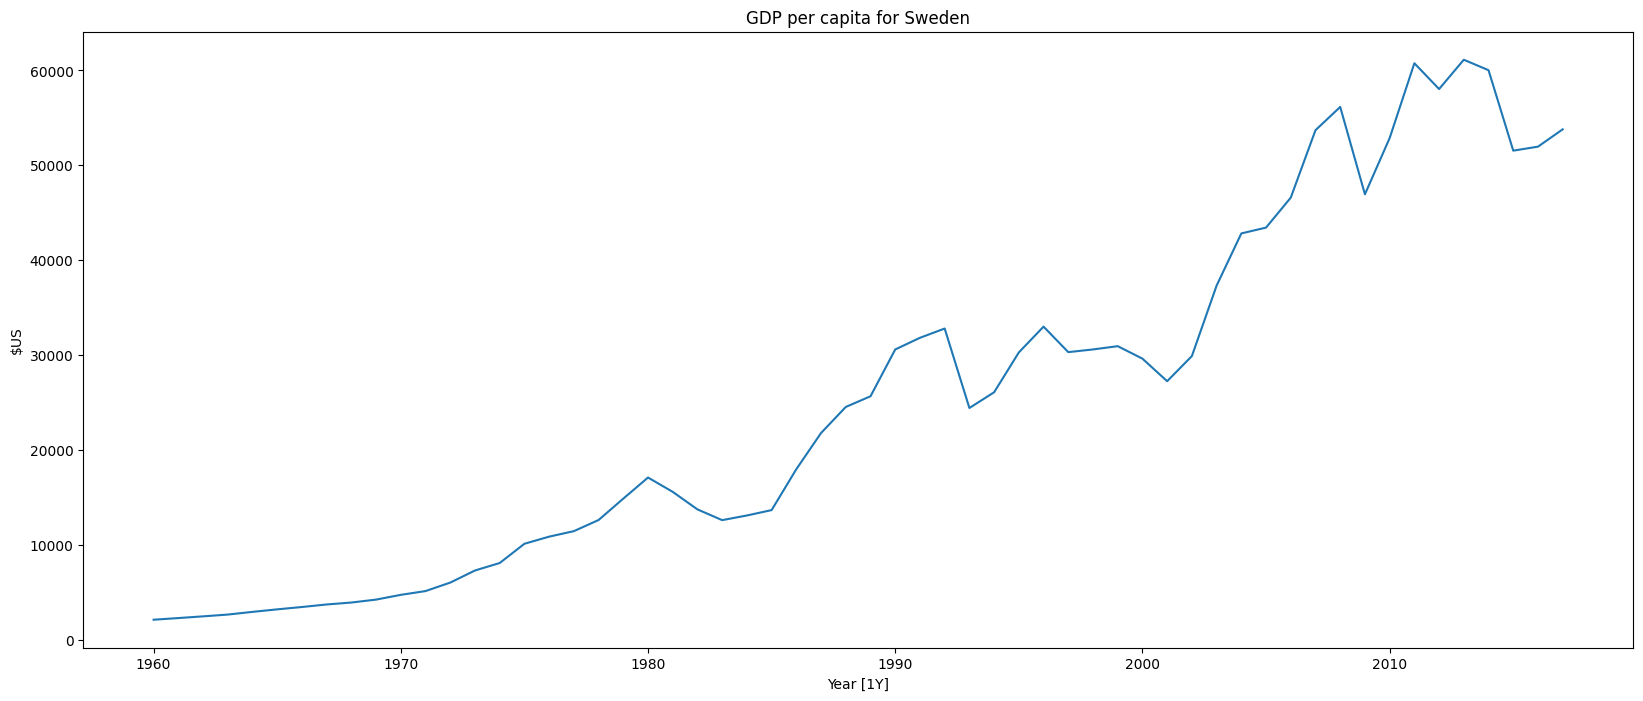

In [45]:
fig = plt.figure(figsize=(20,8))
ax = plt.axes()

# Specify graph features
plt.title("GDP per capita for Sweden")
plt.xlabel("Year [1Y]")
plt.ylabel("$US")

ax.plot( df["Year"], df["Sweden_gdp_per_cap"])

<p style="text-align: center;">
Figure 1: GDP per capita data for Sweden from 1960 to 2017.
</p>

## Define a model (specify)

There are many different time series models that can be used for forecasting, and much of this book is dedicated to describing various models. Specifying an appropriate model for the data is essential for producing appropriate forecasts.

*For example, it´s possible to use an `ETS model` to study the time series of GDP per capita.*

*The exponential smoothing (ETS) algorithm is especially suited for data with seasonality and trend. ETS computes a weighted average over all observations in the input time series dataset as its prediction. In contrast to moving average methods with constant weights, ETS weights exponentially decrease over time, capturing long term dependencies while prioritizing new observations.*

In [46]:
#Import the model that we are going to use:
from statsforecast import StatsForecast
from statsforecast.models import AutoETS as ETS

*AutoETS model Automatically selects the best ETS (Error, Trend, Seasonality) model using an information criterion. Default is Akaike Information Criterion (AICc), while particular models are estimated using maximum likelihood. The state-space equations can be determined based on their `M` multiplicative, `A` additive, `Z` optimized or `N` ommited components. The model string parameter defines the ETS equations: E in `[M A Z]`, T in `[N A M Z]`, and S in `[N A M Z]`.*

*For example when model=‘ANN’ (additive error, no trend, and no seasonality), ETS will explore only a simple exponential smoothing.*

*If the component is selected as ‘Z’, it operates as a placeholder to ask the AutoETS model to figure out the best parameter.*

## Train the model (estimate)

Once an appropriate model is specified, we next train the model on some data. To estimate the model in our example, we use:

In [47]:
# Create an array with the observed values in Sweden_gdp_per_cap:
y_sweden_gdp_per_cap = df["Sweden_gdp_per_cap"].values

# Create a dataframe with the observed values in Sweden_gdp_per_cap and date index:
Y_df = df[["Year","Sweden_gdp_per_cap"]]
Y_df.columns = ["ds","y"]

In [48]:
# for ets we pass a ZMZ model (Multiplicative trend, optimal error and seasonality) which stands for error selected optimally:
ets = ETS(model='ZMZ',
          season_length=4)
ets = ets.fit(y=y_sweden_gdp_per_cap)

This fits a ETS model to the GDP per capita data for Sweden

## Check model performance (evaluate)

Once a model has been fitted, it is important to check how well it has performed on the data. There are several diagnostic tools available to check model behaviour, and also accuracy measures that allow one model to be compared against another. Sections 8 and 9 go into further details.

## Produce forecasts (forecast)

With an appropriate model specified, estimated and checked, it is time to produce the forecasts using `.predict()`. The easiest way to use this function is by specifying the number of future observations to forecast. For example, forecasts for the next 10 observations can be generated using `h = 10`. We can also use natural language; e.g., `h = "2 years"` can be used to predict two years into the future.

In other situations, it may be more convenient to provide a dataset of future time periods to forecast. This is commonly required when your model uses additional information from the data, such as exogenous regressors. Additional data required by the model can be included in the dataset of observations to forecast.

In [49]:
# Make predictions with ETS model:
horizon = 3
y_hat_dict = ets.predict(h=horizon)
y_hat_dict

{'mean': array([55573.24697785, 57414.00914268, 59276.49991915])}

In [50]:
# Specify the years predicted
years_pred = [2018,2019,2020]

# Create a dataframe with the years and values predicted
Y_pred_df = pd.DataFrame({'ds':years_pred,
                        'ETS':y_hat_dict["mean"]})

The forecasts can be plotted along with the historical data using matplotlib as follows:

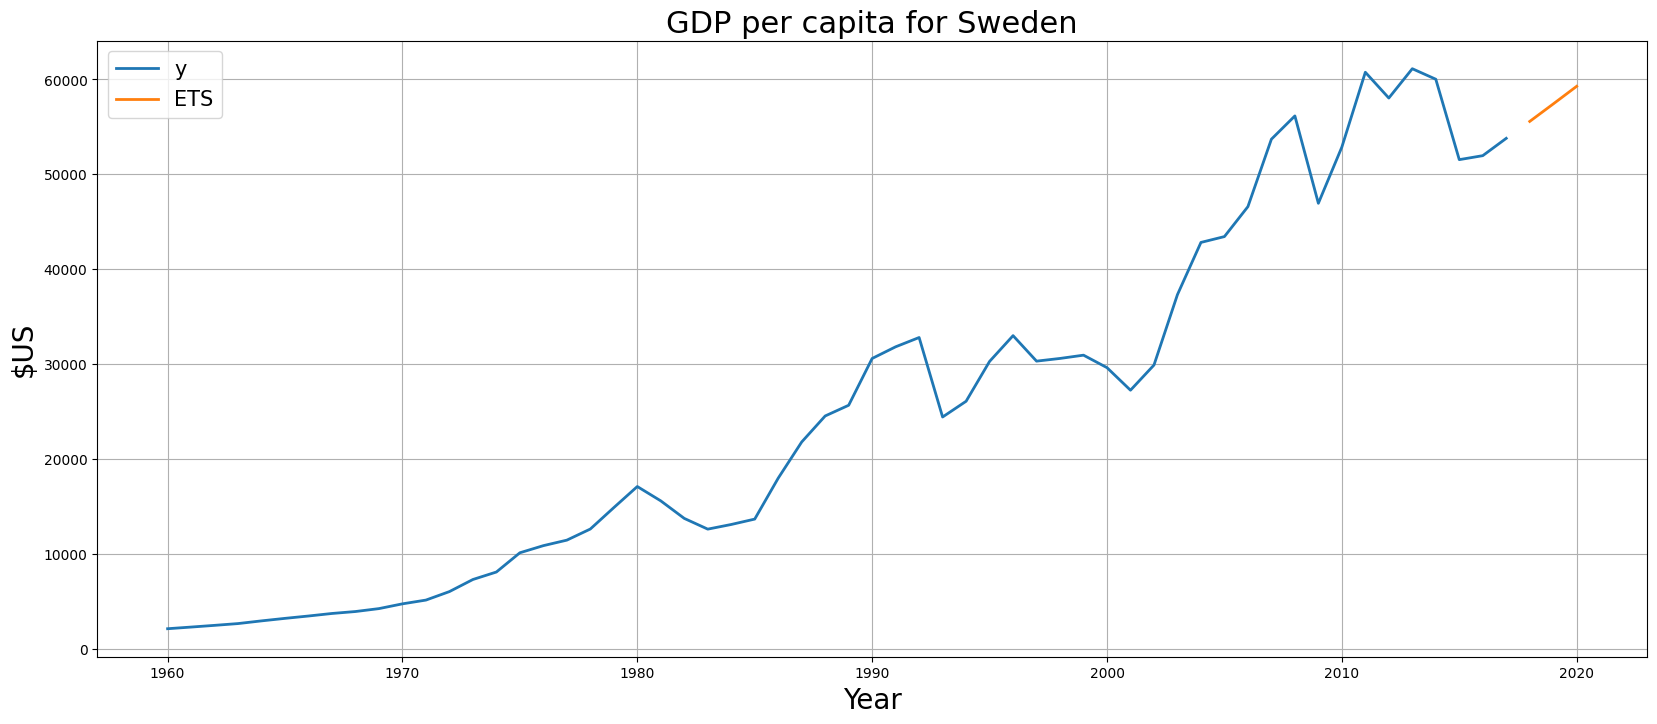

In [51]:
fig, ax = plt.subplots(1, 1, figsize = (20, 8))

# Concatenate the dataframe of predicted values with the dataframe of observed values
plot_df = pd.concat([Y_df, Y_pred_df]).set_index('ds')
plot_df[['y', 'ETS']].plot(ax=ax, linewidth=2)

# Specify graph features
ax.set_title('GDP per capita for Sweden', fontsize=22)
ax.set_ylabel('$US', fontsize=20)
ax.set_xlabel('Year', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

<p style="text-align: center;">
Figure 2: Forecasts of GDP per capita for Sweden using a simple trend model.
</p>